In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import netCDF4 as nc
from scipy.io import loadmat

In [3]:
## Extract a contour line 
def extract_contours(bath, n = 0, depth = -2000): # Grab contour line
    fig, ax = plt.subplots(figsize=(30,10))
    cs = ax.contour(XC, YC, bath, levels=[depth])
    lines = cs.collections[0].get_paths()[n]  # grab the 1st path
    lines = lines.vertices
    plt.close('all')
    return lines

In [4]:
## Convert contour lats, lons to model i, j 
def to_model_indices(lats, lons, YC, XC): # Convert lat lon to model ij
    idx = []
    idy = []

    for i in range(len(lats)):
        ix = np.argmin(abs(XC - lons[i]))
        iy = np.argmin(abs(YC - lats[i]))
    
        test = np.logical_and(np.asarray(idx) == ix, np.asarray(idy) == iy)
    
        if test.any():
            continue
        else:
            idx.append(ix)
            idy.append(iy)

    idx = idx[::-1]
    idy = idy[::-1]

    idx = np.asarray(idx)
    idy = np.asarray(idy)
    return idy, idx

In [5]:
## Create a mask SOUTH of the contour line 
def create_mask(ref, idy, idx, nloop = 1): 

    mask = np.zeros(ref.shape)  ## Create mask same size as bathymetry
    mask[:] = np.nan 

    for i in range(len(idy)): ## create border
        mask[idy[i], idx[i]] = 9
    
    
    for j in range(mask.shape[1]): ## simple fill
        for i in range(mask.shape[0]):
            if mask[i,j] == 9:
                mask[:i, j] = 1
                break
                
    for _ in range(nloop):
        
        for i in range(1, mask.shape[0]-1): ## Complex fill 
            for j in range(1, mask.shape[1]-1):
                if mask[i,j] ==9:
                    continue
                if mask[i + 1, j] == 1 or mask[i -1, j] == 1 or mask[i, j + 1] == 1 or mask[i, j -1] == 1:
                    mask[i, j] =1 
                    
        for i in range(mask.shape[0]-2, 0, -1):
            for j in range(mask.shape[1]-2, 0, -1):
                if mask[i,j] ==9:
                    continue
                if mask[i + 1, j] == 1 or mask[i -1, j] == 1 or mask[i, j + 1] == 1 or mask[i, j -1] == 1:
                    mask[i, j] =1 
            
    mask[mask == 9] = 1

    return mask 

In [6]:
## Stair stepping along the mask
def mk_ij(mask, target = 1, land = 0, ocean = 2):
    
    ## Find boundary between target region and ocean 
    bmask = np.zeros(mask.shape)

    for i in range(bmask.shape[0]): # iterate through y
        for j in range(bmask.shape[1]): # iterate through x
            if mask[i,j] == target: # if grid is within target 
                i_up = i+1
                i_down = i-1
                j_right = j+1
                j_left = j-1
                
                if i_up < mask.shape[0]-1 and mask[i_up, j] == ocean: # Check up
                    bmask[i_up, j] = 1
                    
                if i_down > 0 and mask[i_down, j] == ocean:# Check down
                    bmask[i_down, j] = 1
                    
                if  j_right < mask.shape[1]-1 and mask[i, j_right] == ocean: # Check Right
                    bmask[i, j_right] = 1
                
                if j_left > 0 and mask[i, j_left] == ocean: # Check Left
                    bmask[i, j_left] = 1
                        
    ## Identify I-J indices
    I = []
    J = []
    d = []

    for i in range(bmask.shape[0]):
        for j in range(bmask.shape[1]):
            if bmask[i,j] == 1: ## at boundary cell, search to find what direction the target region is
                i_up = i+1
                i_down = i-1
                j_right = j+1
                j_left = j-1

                if i_up < mask.shape[0]-1 and mask[i_up, j] == target: 
                    # Target is above, +V is into target | Velocity @ top boundary (i+1, j)
                    I.append(i+1)
                    J.append(j)
                    d.append('+V')
     
                if i_down > 0 and mask[i_down, j] == target:
                    # Target is below, -V is into target | Velocity @ bottom boundary (i, j)
                    I.append(i)
                    J.append(j)
                    d.append('-V')
                
                    
                if  j_right < mask.shape[1]-1 and mask[i, j_right] == target: 
                    # Target is right, +U is into target | Velocity @ right boundary (i, j+1)
                    I.append(i)
                    J.append(j+1)
                    d.append('+U')
                    
    
                if j_left > 0 and mask[i, j_left] == target:
                    # Target is left, -U is into target | Velocity @ left boundary (i, j)
                    I.append(i)
                    J.append(j)
                    d.append('-U')
                    
    return I, J, d


# Example

In [7]:
## Load XC, YC
SOSE = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOSE/SOSE_iter100.nc')
YC = SOSE['lat'][:]
XC = SOSE['lon'][:] %360

## Load Bathymetry
grid = loadmat('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOSE/grid.mat')
bath = -grid['Depth'][:,:138]
bath = np.swapaxes(bath, 1,0)

/home/a4dinh/.conda/envs/parcels/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


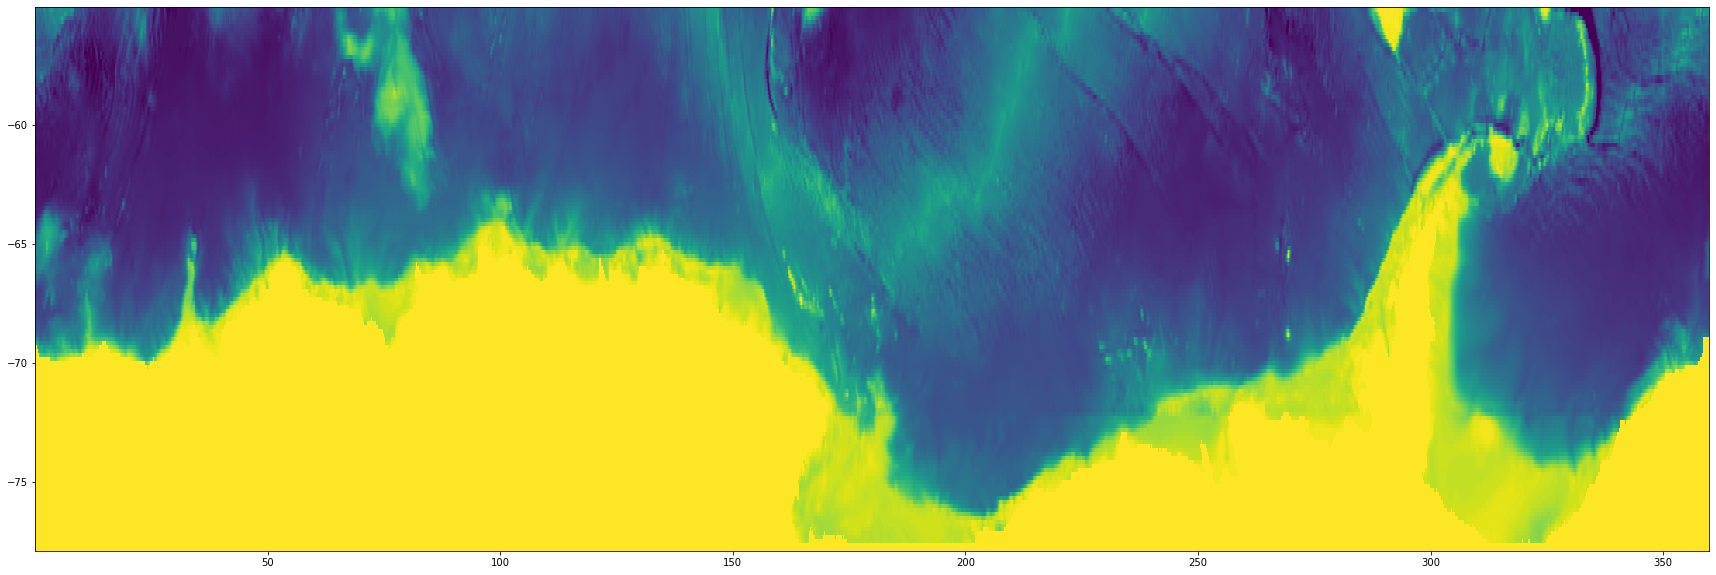

In [8]:
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(XC, YC, bath)

(2996, 2)


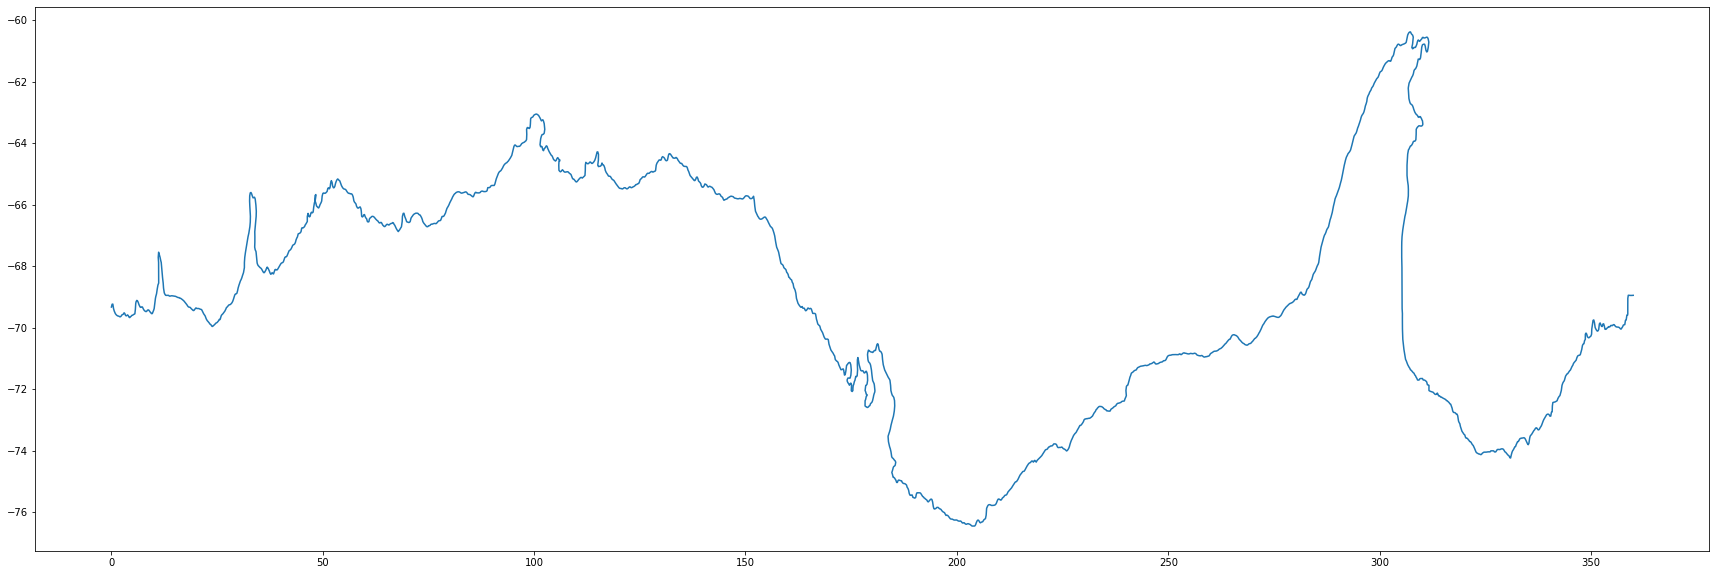

In [9]:
## Extract contour line
## Make sure the correct line is extracted, modify n if needed

contour_line = extract_contours(bath, n = 0, depth = -2000)
print(contour_line.shape)

lats = contour_line[:, 1]
lons = contour_line[:, 0]

fig, ax = plt.subplots(figsize=(30,10))
ax.plot(lons, lats)

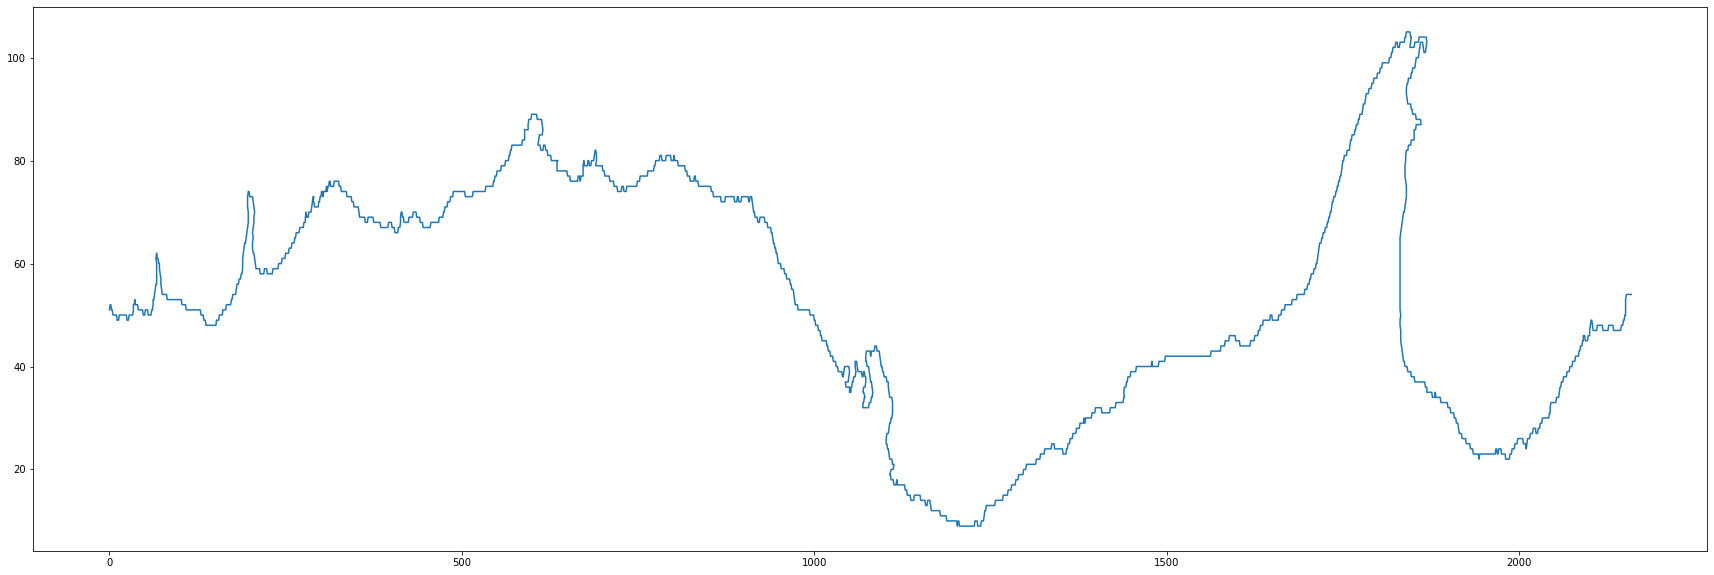

In [10]:
## Convert to model indices
index_y, index_x = to_model_indices(lats, lons, YC, XC)
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(index_x, index_y)

In [11]:
## Create mask
mask = create_mask(bath, index_y, index_x, nloop = 1)

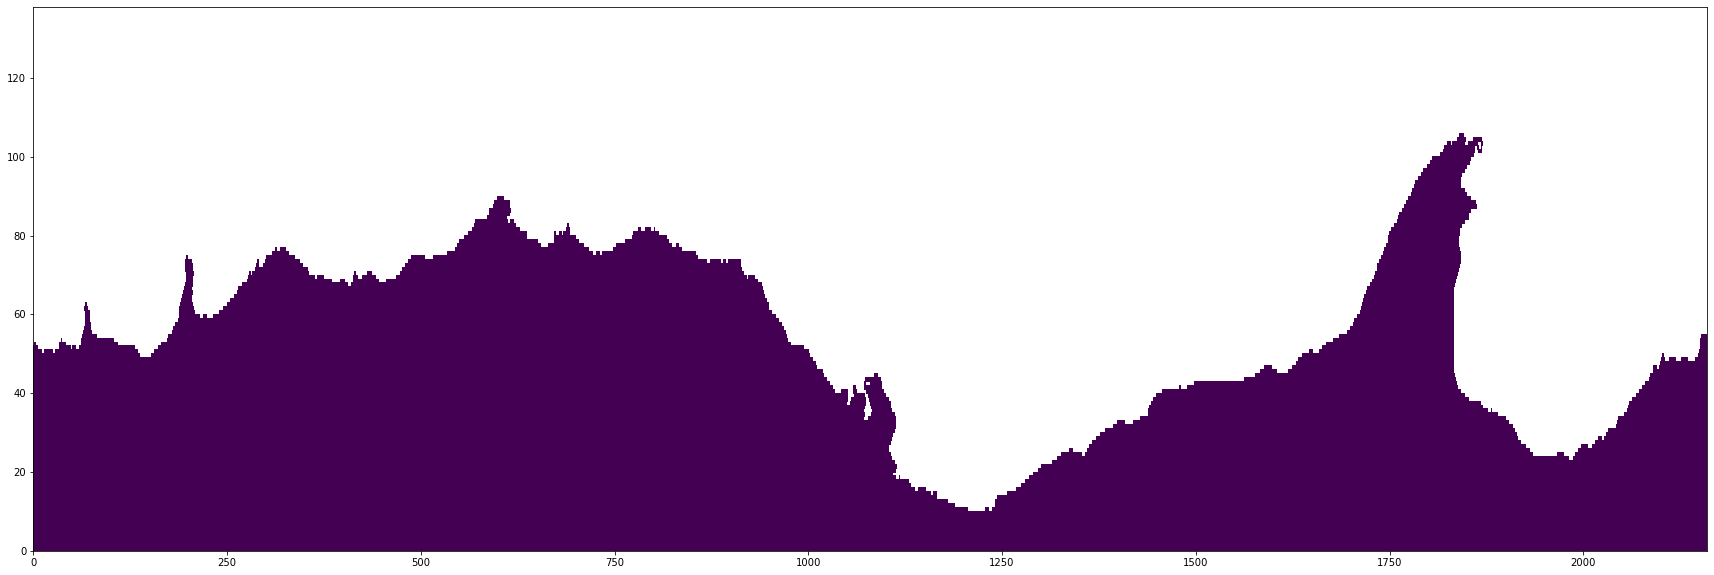

In [12]:
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(mask)

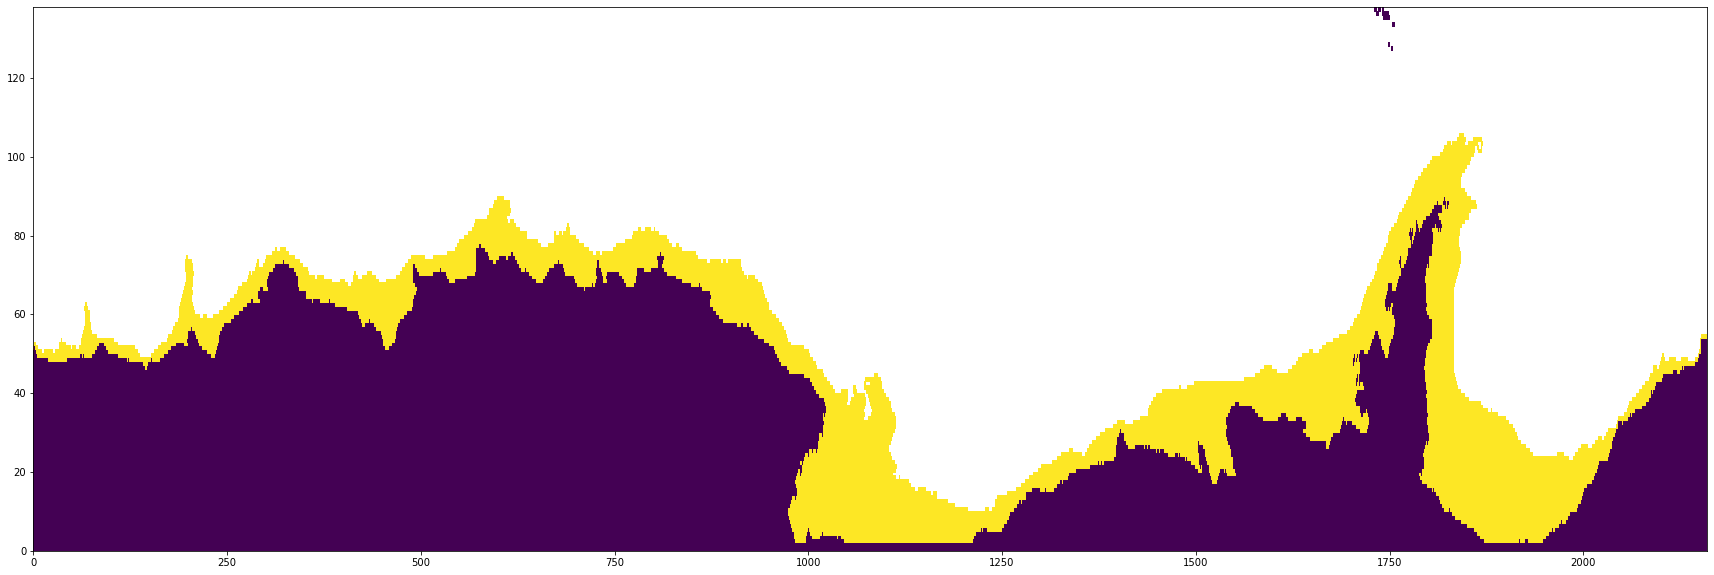

In [13]:
## Fill Land with 0
mask[bath==0] = 0
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(mask)

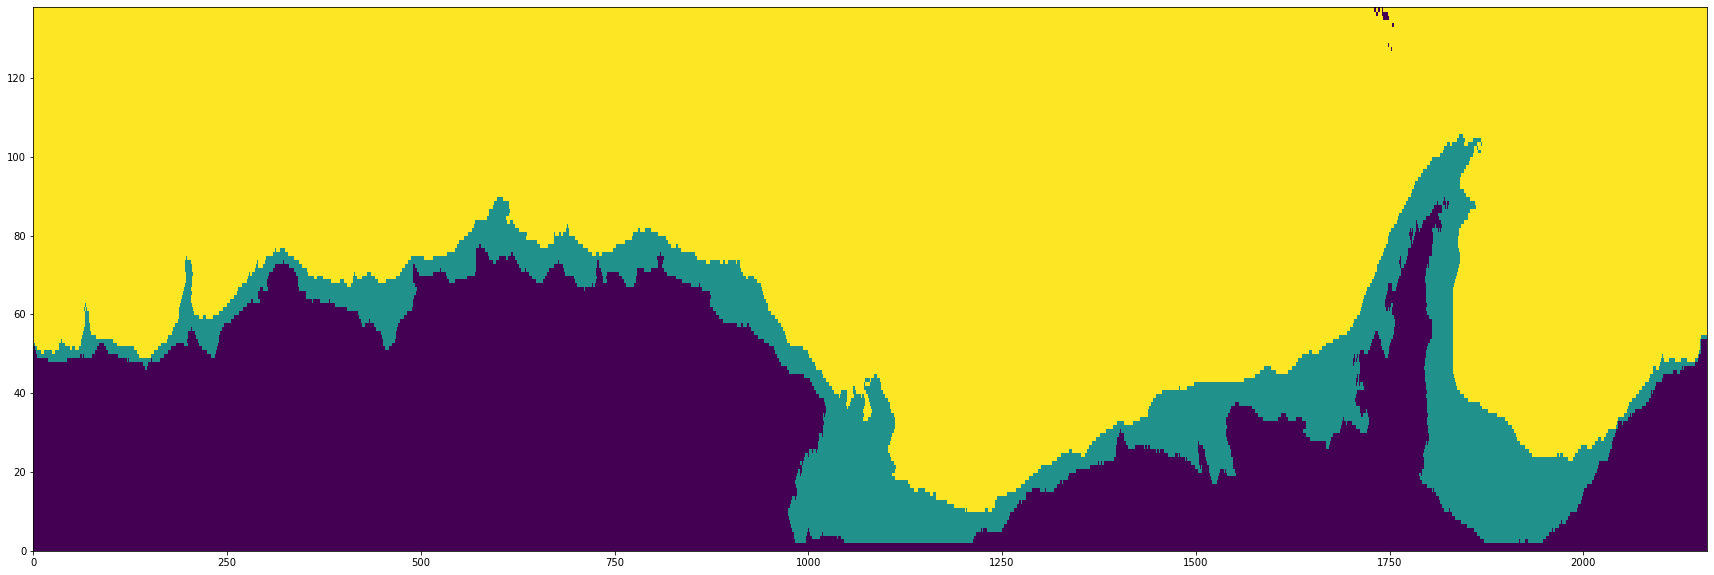

In [14]:
## Fill ocean with 2
mask[np.isnan(mask)]=2
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(mask)

## Generate I, J indices

In [15]:
## Stair-stepping along target - ocean boundary

I, J, d = mk_ij(mask, 
               target =1, 
               land = 0,
               ocean = 2)

(60.0, 110.0)

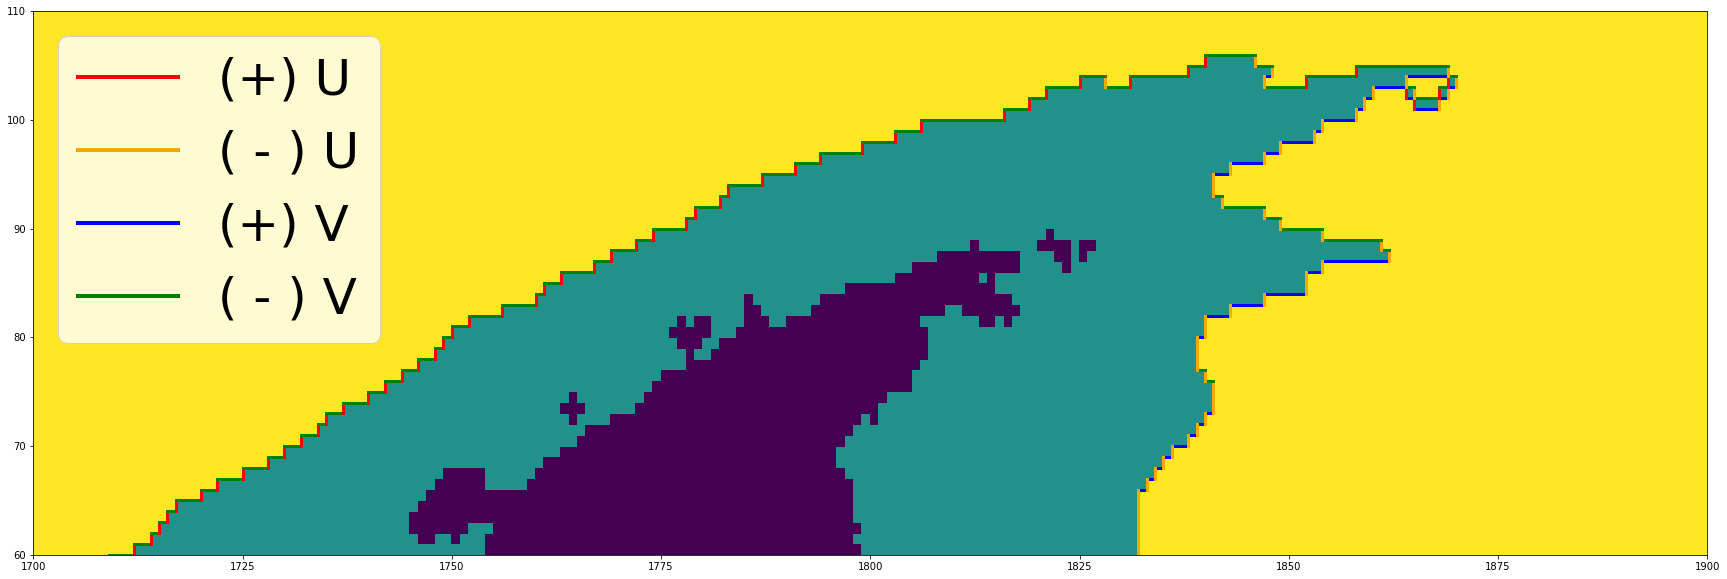

In [16]:
fig, ax = plt.subplots(figsize=(30,10))

ax.pcolormesh(mask)

for i in range(len(I)):
    if d[i] == '+U':
        ax.plot([J[i], J[i]],
                   [I[i],I[i]+1], color='red', lw=3)
    if d[i] == '-U':
        ax.plot([J[i], J[i]],
                   [I[i],I[i]+1], color='orange', lw=3)
    if d[i] == '+V':
        ax.plot([J[i], J[i]+1],
                   [I[i],I[i]], color='blue', lw=3)
    if d[i] == '-V':
        ax.plot([J[i], J[i]+1],
                   [I[i],I[i]], color='green', lw=3)


custom_lines = [Line2D([0], [0], color='red', lw=4),
               Line2D([0], [0], color='orange', lw=4),
               Line2D([0], [0], color='blue', lw=4),
               Line2D([0], [0], color='green', lw=4)]

ax.legend(custom_lines, ['(+) U', '( - ) U', '(+) V', '( - ) V'], fontsize=50)

ax.set_xlim(1700, 1900)
ax.set_ylim(60,110)